Get dataset from https://github.com/OlafenwaMoses/FireNET
combine train and validate source sets, as these are split in code

https://airctic.com/retinanet/

In [1]:
!wget https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip -q

In [3]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
replace fire-dataset/train/annotations/img (100).xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fire-dataset/train/annotations/img (100).xml  
replace fire-dataset/train/annotations/img (101).xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: fire-dataset/train/annotations/img (101).xml  
  inflating: fire-dataset/train/annotations/img (102).xml  
  inflating: fire-dataset/train/annotations/img (103).xml  
  inflating: fire-dataset/train/annotations/img (104).xml  
  inflating: fire-dataset/train/annotations/img (105).xml  
  inflating: fire-dataset/train/annotations/img (106).xml  
  inflating: fire-dataset/train/annotations/img (107).xml  
  inflating: fire-dataset/train/annotations/img (108).xml  
  inflating: fire-dataset/train/annotations/img (109).xml  
  inflating: fire-dataset/train/annotations/img (110).xml  
  inflating: fire-dataset/train/annotations/img (111).xml  
  inflating: fire-dataset/train/annotations/img (112).xml  
  inf

In [4]:
!rm  fire-dataset.zip

In [5]:
cp fire-dataset/validation/annotations/* fire-dataset/train/annotations/

In [6]:
cp fire-dataset/validation/images/* fire-dataset/train/images/

In [7]:
!rm  -r fire-dataset/validation/

In [8]:
!ls fire-dataset/train

annotations  images


Install from master

In [9]:
!pip install  icedata
!pip install icevision[all]
# !pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade

     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 122kB 38.2MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 61kB 11.2MB/s 
     |████████████████████████████████| 81kB 13.7MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 552kB 47.9MB/s 
     |████████████████████████████████| 1.8MB 51.9MB/s 
     |████████████████████████████████| 194kB 61.5MB/s 
     |████████████████████████████████| 112kB 56.7MB/s 
     |████████████████████████████████| 952kB 45.0MB/s 
     |████████████████████████████████| 36.7MB 92kB/s 
     |████████████████████████████████| 92kB 14.5MB/s 
     |████████████████████████████████| 163kB 54.2MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 133kB 47.0MB/s 
     |████████████████████████████████| 102kB 16.1MB/s 
  

In [10]:
from icevision.all import *

In [12]:
data_dir = Path('fire-dataset/train')
data_dir

Path('fire-dataset/train')

In [13]:
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [14]:
image_files = [i for i in images_dir.glob('*')]
image_files[:3]

[Path('fire-dataset/train/images/img (6).jpg'),
 Path('fire-dataset/train/images/pic (15).jpg'),
 Path('fire-dataset/train/images/pic (204).jpg')]

In [15]:
annotation_files = [i for i in annotations_dir.glob('*')]
annotation_files[:3]

[Path('fire-dataset/train/annotations/img (35).xml'),
 Path('fire-dataset/train/annotations/small (45).xml'),
 Path('fire-dataset/train/annotations/small (37).xml')]

In [16]:
class_map = ClassMap(['fire'])

In [17]:
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

In [18]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

INFO     - Autofixing records | icevision.parsers.parser:parse:124


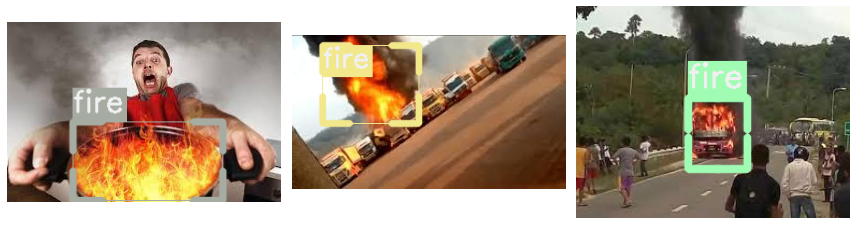

In [19]:
show_records(train_records[:3], ncols=3, class_map=class_map)

In [20]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

The Dataset class combines the records and transforms.

In [21]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Displaying the same image with different transforms

In [22]:
samples = [train_ds[3] for _ in range(6)]
# show_samples(samples, ncols=3, class_map=class_map)

In [23]:
model = retinanet.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


Each model has its own dataloader (a pytorch `DataLoader`) that could be customized: the dataloaders for the RCNN models have a custom collate function.

In [24]:
# DataLoaders
train_dl = retinanet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = retinanet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

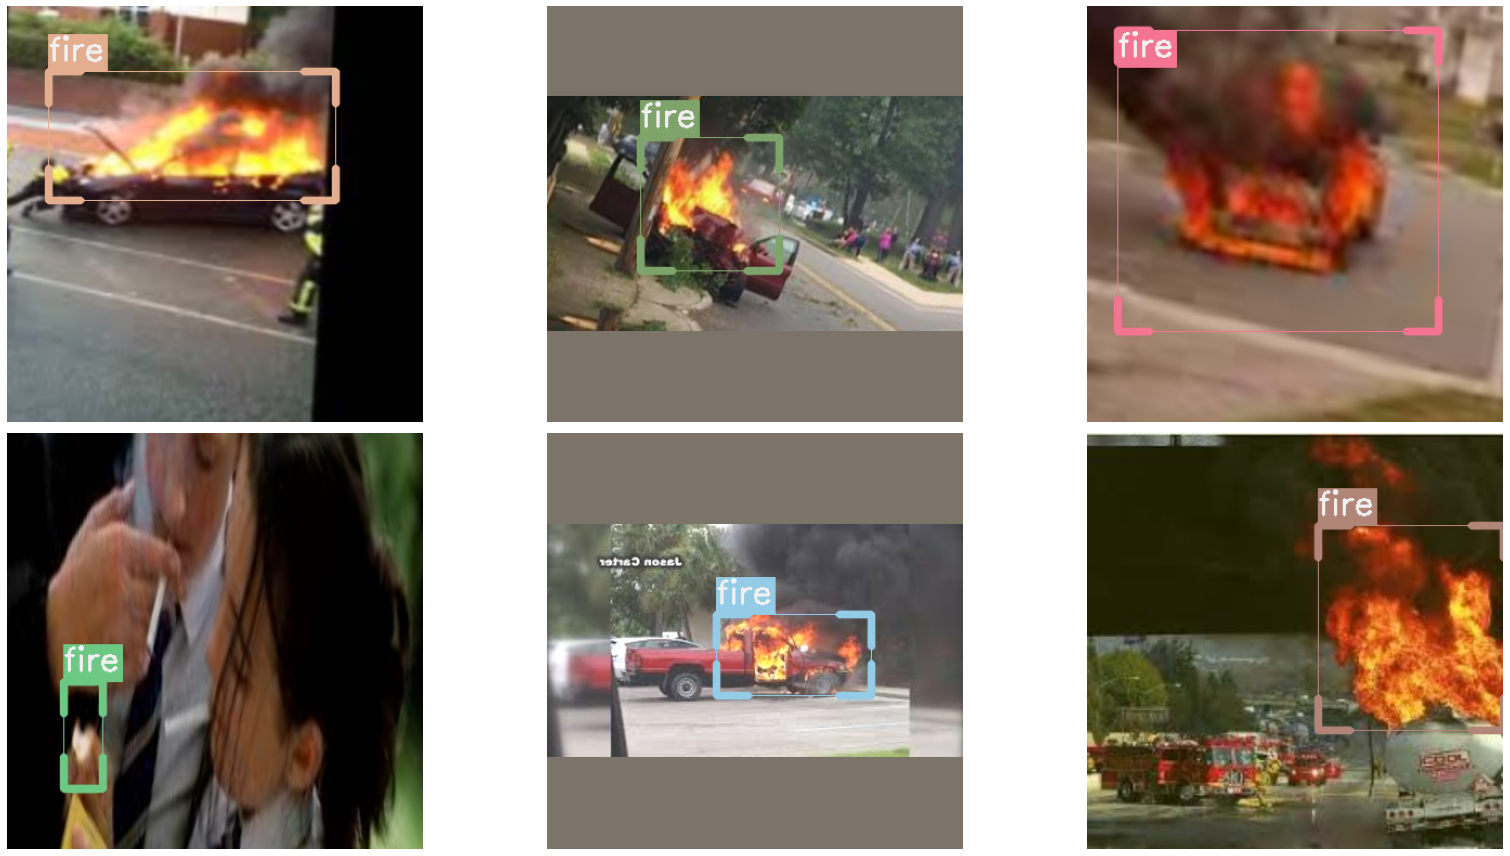

In [25]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=3)

IceVision is an agnostic framework meaning it can be plugged to multiple DL frameworks such as fastai, and pytorch-lightning. 

Metrics are essential for tracking the model progress as it's training.
Here we are going to be using the well established COCOMetric, which reports on the mean average precision of the predictions.

In [26]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [27]:
# Fastai Learner
learn = retinanet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [28]:
learn.freeze()
learn.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


IndexError: ignored

The fastai fine_tune method is useful when you have a pre-trained model, which we are using. It does an initial epoch where it freezes everything except its final layers. It then carries on for the indicated number of epochs using a differential learning rate to train the whole model. It adjusts the learning rate both across the layers of the model as well as across the epochs. This can give excellent results with reduced training time.

In [27]:
learn.fine_tune(50, 3e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,5.915319,1.804473,0.000000,00:24


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch,train_loss,valid_loss,COCOMetric,time
0,1.415003,1.421489,0.003180,00:36
1,1.231857,1.107379,0.023210,00:33
2,1.111896,1.040621,0.050930,00:33
3,1.006533,0.869584,0.135291,00:33
4,0.961499,0.852585,0.162567,00:33
5,0.911316,0.730761,0.226020,00:33
6,0.867693,0.992771,0.113037,00:33
7,0.821495,0.849876,0.192085,00:33
8,0.832168,0.977712,0.096226,00:32
9,0.862617,0.843193,0.177870,00:32


IndexError: ignored

In [ ]:
infer_dl = retinanet.infer_dl(valid_ds, batch_size=8)
samples, preds = retinanet.predict_dl(model, infer_dl)

In [ ]:
show_preds(
    samples=samples[:6],
    preds=preds[:6],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

https://airctic.github.io/icedata/how-to/#how-to-save-trained-weights-in-google-colab

In [ ]:

## Saving a Model on Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

torch.save(model.state_dict(), root_dir/'models/icedata/retinanet_fire.pth')

`"retinanet_fire.pth" (XXMB)`

In [ ]:
ls